In [1]:
# import cf, cfplot as cfp
import numpy as np
import scipy as sp
import sys
import os
from netCDF4 import Dataset
import netCDF4 as nc

%matplotlib inline
import matplotlib
import xarray as xr
import matplotlib.pyplot as plt
import warnings

import matplotlib.pyplot as plt
import matplotlib.path as mpath
# Quick plot to show the results
from cartopy import config
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import scipy.ndimage as ndimage0
# from mpl_toolkits.basemap import Basemap
# from mpl_toolkits.basemap import addcyclic
from cartopy.util import add_cyclic_point
import matplotlib.pylab as pl
from scipy import stats
import regionmask
import glob
import dask
from general_functions import *
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
reg='IPCC'
nyear=1
rebasing=False # wether or not to shift all stabilisation runs to have the same nominal start date (offset = 0). 
#If false, the stabilisation runs will all start from their branch dates (i.e. 2014,2020,2025,2040 etc.)

def rebase(dataset,files):
    # ds = xr.open_dataset('intermediate_files/stable/gmst/tas_gmst_bq777.nc') #,engine='zarr')
    dates=dataset[0,].dropna(dim='year',how='all').year  
    datasets = []
    test=dataset
    for i in np.arange(0,int(dataset.shape[0])):
        tmp=test[i,:].dropna(dim='year',how='all')
        tmp['year']=dates
        datasets.append(tmp)
    dsnew = xr.concat(datasets, dim='cases')
    return(dsnew)

def preprocess(ds):
    print(ds.encoding['source'])
    return(ds)

def seasaverage_3(var,seas,singlemonth=False,window=3):
    if (window == 3):
        season={'DJF':0,'JFM':1,'FMA':2,'MAM':3,'AMJ':4,'MJJ':5,'JJA':6,'JAS':7,'ASO':8,'SON':9,'OND':10,'NDJ':11,'ann':None}
        seasindex=season[seas]
        if (seas == 'ann'):
            var_seas=var.groupby('time.year').mean('time')
        else:
            if (var.ndim == 4):
                var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[:,seasindex::12,:,:]
                var_seas=var_seas.groupby('time.year').mean('time') #
                
            elif (var.ndim == 3): 
                var_seas=var.rolling(min_periods=3, center=True, time=3).mean()[seasindex::12,:,:]
                var_seas=var_seas.groupby('time.year').mean('time')
            print(var_seas)
    elif (window==1):
        month={0:'January',1:'February',2:'March',3:'April',4:'May',5:'June',6:'July',7:'August',8:'September',9:'October',10:'November',11:'December'}
        if (var.ndim == 4):
            var_seas=var[:,seas::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time')
        elif (var.ndim == 3): 
            var_seas=var[seas::12,:,:]
            var_seas=var_seas.groupby('time.year').mean('time')
        print(month[seas])   
    elif (window==5):
        season={'MJJAS':6,'ann':None}
        seasindex=season[seas]
        if (seas == 'ann'):
            var_seas=var.groupby('time.year').mean('time')
        else:
            if (var.ndim == 4):
                var_seas=var.rolling(min_periods=5, center=True, time=5).mean()[:,seasindex::12,:,:]
                var_seas=var_seas.groupby('time.year').mean('time') #
                
            elif (var.ndim == 3): 
                var_seas=var.rolling(min_periods=5, center=True, time=5).mean()[seasindex::12,:,:]
                var_seas=var_seas.groupby('time.year').mean('time')
            print(var_seas)   
    return(var_seas)

# def pick_month(var,index):
#     month={0:'January',1:'February',2:'March',3:'April',4:'May',5:'June',6:'July',7:'August',8:'September',9:'October',10:'November',11:'December'}
#     if (var.ndim == 4):
#         var_seas=var[:,index::12,:,:]
#         var_seas=var_seas.rename({"time":"year"})
#     elif (var.ndim == 3): 
#         var_seas=var[index::12,:,:]
#         var_seas=var_seas.rename({"time":"year"})
#     print(month[index])
#     return(var_seas)

zipgmststab=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_*.nc'))
zipgmst=xr.open_mfdataset(zipgmststab,combine='nested',concat_dim='cases',preprocess=preprocess)['tas']
zipgmst=np.nanmean(rebase(zipgmst,zipgmststab),axis=1)
# print(zipgmst)
def sortbygmst(input):
    input = [x for _,x in sorted(zip(zipgmst,input))]
    return(input)


gmststab=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_*.nc')))
gmst=xr.open_mfdataset(gmststab,combine='nested',concat_dim='cases',preprocess=preprocess)['tas']
gmst=rebase(gmst,gmststab)
gmstbase=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/historical/gmst/tas_gmst_*.nc'))
gmstref=xr.open_mfdataset(gmstbase,combine='nested',concat_dim='cases')['tas']
base=gmstref[:,0:50].mean('cases').mean('year')
gmst2=gmst-base


/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bq777.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bu607.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw848.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw987.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bz227.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_cd269.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bq777.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw848.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bz227.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_cd269.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/gmst/tas_gmst_bw987.nc
/gws/nopw/j04/realproj/users/adittus/intermediate_file

## PART1 : Figure 3 ##

In [3]:
reg='IPCC'
seas='JJA'
var='pr'
ssp119_inds=[0,1,2,3,7]
stable={}
transient={}
hist={}
stable_r={}
region={}
cat={}
gmst_ssp={}
scenario=['ssp370']
if (seas == "DJF"):
    sind=1
else:
    sind=0
for s in scenario:
    print(s)
    for r in [16,19]:
        # var='pr_'+str(r)
        stable[s+'_'+str(r)]=xr.open_dataset('timeseries/'+var+'_'+reg+'_'+seas+'_stable_land.nc')['pr_region_mean'][:,:,r]
        if (s=='ssp119'):
            hist['hist_'+str(r)]=xr.open_dataset('timeseries/'+var+'_'+reg+'_'+seas+'_hist_land.nc')['pr_region_mean'][ssp119_inds,:,r]
        else: 
            hist['hist_'+str(r)]=xr.open_dataset('timeseries/'+var+'_'+reg+'_'+seas+'_hist_land.nc')['pr_region_mean'][:,:,r]
        transient[s+'_'+str(r)]=xr.open_dataset('timeseries/'+var+'_'+reg+'_'+seas+'_'+s+'_land.nc')['pr_region_mean'][:,:,r]
        region[s+'_'+str(r)]=xr.open_dataset('timeseries/'+var+'_'+reg+'_'+seas+'_stable_land.nc')['names'][r].values
        cat[s+'_'+str(r)]=xr.concat([hist['hist_'+str(r)],transient[s+'_'+str(r)]],dim='year')
print(cat)
for s in scenario:
    gmstssp=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/'+s+'/gmst/tas_gmst_*.nc'))
    gmstsspt=xr.open_mfdataset(gmstssp,combine='nested',concat_dim='cases')['tas']
    gmst_ssp[s]=gmstsspt-base

ssp370
{'ssp370_16': <xarray.DataArray 'pr_region_mean' (run: 16, year: 251)>
array([[ -3.80348403,   9.48738584,  10.61282097, ...,  -6.08118077,
        -42.41032261, -12.75612721],
       [ -9.35798763,   5.32539335, -15.5664864 , ...,  -4.03766426,
         -2.9033128 , -19.57192459],
       [-12.16664908,  -5.31583264,  23.74521489, ...,  -9.58875679,
         -0.59778271,  17.04914667],
       ...,
       [ -6.14303128,  -4.05780543,  -8.94477364, ...,   4.94343503,
        -13.81831505,   7.84180333],
       [  3.08228342,  -7.6963808 , -27.72158056, ..., -17.22056878,
         12.76723704,  -2.72323528],
       [ 15.31421045,  -2.57964976,  -8.58047542, ...,   3.05852724,
         -7.03552436,  -3.55183695]])
Coordinates:
    type     |S4 b'land'
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: run, 'ssp370_19': <xarray.DataArray 'pr_region_mean' (run: 16, year: 251)>
array([[-12.28453025, -16.31948509,  30.25209093

In [4]:
var='jet'
stable[var]=xr.open_dataset('timeseries/jet_lat_JJA.nc')['jet_lat_Atlantic_stable'].rename({'year_1':'year'}) #,gmststab)
print(stable[var].shape)
transient[var]=xr.open_dataset('timeseries/jet_lat_JJA.nc')['jet_lat_Atlantic_transient'].rename({'year_2':'year'})
stable_r[var]=rebase(stable[var],gmststab)
# plt.plot(np.moveaxis(transient[var].values,0,1))

(6, 526)


16
stable 0.9063135052765507
stable 1.2758266545160504
stable 2.1743181976997445
stable 1.3646927927199406
stable 1.728595513747258
stable 1.2241998325062722
stable 1.0817337839608543
stable 0.59216735647208
stable 1.0206273360041227
stable 1.6057238618304739
stable 1.2732538638482918
stable 1.7375092277709496


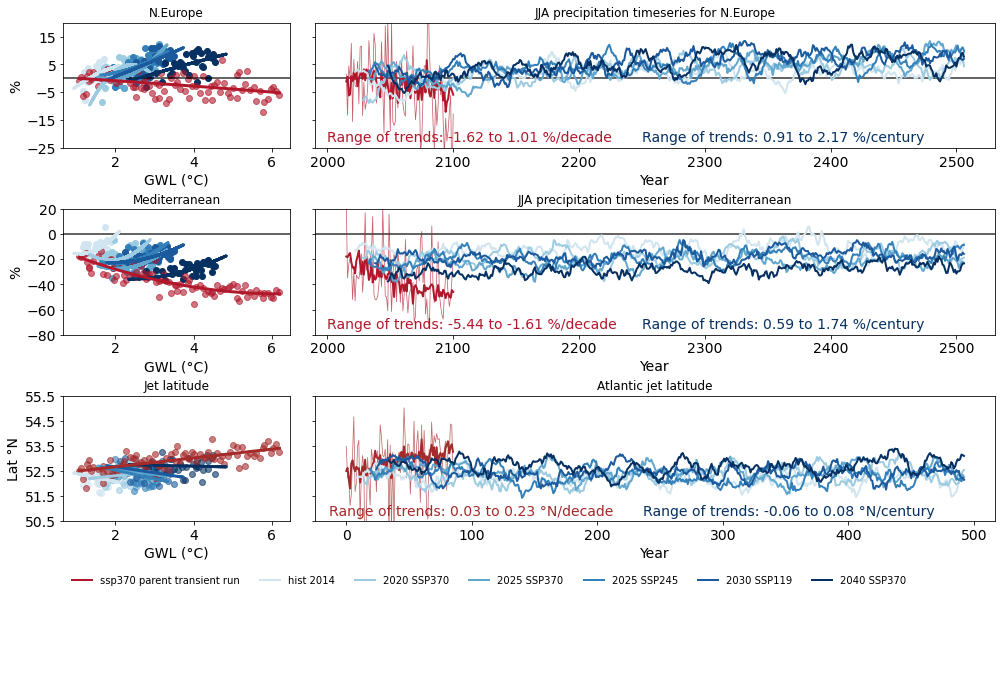

In [5]:
reg='IPCC'
minplot={19:-80.,16:-25} # Axis minimum value depending on region
steps={19:20,16:10} # Axis tickmark spacing
syear=sind+0 # start year
eyear=500 # end year (index)
spacing=16 # spacing plot density for scatterplot (e.g. spacing=16 : every 16th data point is plotted)
cmap = plt.cm.get_cmap('RdBu')
col=np.linspace(0.6,1,6) # color indices for different runs, based on cmap

fig, axarr = plt.subplots(nrows=4, ncols=2, figsize=(3.8+10, 4*2.4), constrained_layout=True,squeeze=False,gridspec_kw={'width_ratios':[1,3]})
ax=axarr.flatten()
ax[0].axhline(y=0, color='black', linestyle='-',alpha=0.8)

## REGION 1 ##
r=16 # region index 16 = Northern Europe
s='ssp370'
var=s+'_'+str(r) # variable "pr" + region index string
nruns=len(gmst_ssp[s][:,0])
print(nruns)

region=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable_land.nc')['names'][r].values

pi=0 # plot index values

stable_r[var]=rebase(stable[var],gmststab) # shift all stabilisation runs to start in the same year
for c in np.arange(0,6):
    ax[pi].scatter(gmst2[c,0:eyear].rolling(year=16,center=True).mean()[::spacing],stable_r[var][c,0:eyear].rolling(year=16,center=True).mean()[::spacing],color=cmap(col[c]),alpha=1)
    fit_stable_1=np.polyfit(x=gmst2[c,sind:eyear].rolling(year=1,center=True).mean().dropna('year'),y=stable_r[var][c,sind:eyear].rolling(year=1,center=True).mean().dropna('year'),deg=2)
    recon_s1=fit_stable_1[0]*(gmst2[c,sind:]**2)+fit_stable_1[1]*gmst2[c,sind:]+fit_stable_1[2]
    # recon_s1=fit_stable_1[0]*(gmst2[r,sind:])+fit_stable_1[1]
    ax[pi].plot(gmst2[c,sind:],recon_s1,color=cmap(col[c]),linewidth=3)
    
fit_transient=np.polyfit(x=np.nanmean(gmst_ssp[s][:,:],axis=0),y=np.nanmean(transient[var][:,:].values,axis=0),deg=2)
recon=fit_transient[0]*((np.nanmean(gmst_ssp[s][:,:],axis=0))**2)+fit_transient[1]*np.nanmean(gmst_ssp[s][:,:],axis=0)+fit_transient[2]
# recon=fit_transient[0]*np.nanmean(gmstssp370[:,:],axis=0)+fit_transient[1]
ax[pi].plot(np.nanmean(gmst_ssp[s][:,:],axis=0),recon,color=cmap(0.1),linewidth=3)
# ax[0].set_title("UK and Ireland")
# ax[0].scatter(gmstssp370[:,::spacing],transient[:,::spacing],c='brown',alpha=0.6)
ax[pi].scatter(np.mean(gmst_ssp[s],axis=0),np.mean(transient[var],axis=0),color=cmap(0.1),alpha=0.6)

# lim=np.round(np.nanmax((np.abs(np.nanmin(test[var][:,:].rolling(min_periods=16, center=True, year=16).mean().values)),
                        # np.nanmax(test[var][:,:].rolling(min_periods=16, center=True, year=16).mean().values),np.abs(np.nanmin(np.mean(regtemp_ssp[var][:,:],axis=0))),np.nanmin(np.mean(regtemp_ssp[var][:,:],axis=0)))),2)

ax[pi].set_xlabel('Year',fontsize=14)
ax[pi].set_ylabel('%',fontsize=14)
ax[pi].set_ylim(ymax = 20., ymin = minplot[r])
# ax[0].yaxis.tick_left()
# locs, labels = plt.yticks()  # Get the current locations and labels.
ax[pi].set_yticks(np.arange(minplot[r],21, step=steps[r]))  # Set label locations.
ax[pi].tick_params(axis='both', which='both', labelsize=14)
ax[pi].set_xlabel('GWL (°C)',fontsize=14)
ax[pi].set_ylabel('%',fontsize=14)
ax[pi].set_title(str(region))

# TIMESERIES
linelist=[]
pi=1
trendlist=np.full(6,np.nan)
trendlist_red=np.full(nruns,np.nan)
ax[pi].axhline(y=0, color='black', linestyle='-',alpha=0.8)
for c in np.arange(0,nruns):
    trendlist_red[c]=transient[var][c,].polyfit(dim='year',deg=1,skipna=True)['polyfit_coefficients'][0]*10
    # print(trendlist_red[c])
ax[pi].plot(transient[var].year.values,transient[var][0,:].values,color=cmap(0.1),linewidth=0.75,alpha=0.7)
lines, = ax[pi].plot(transient[var].year.values,np.mean(transient[var][:,:].values,axis=0),color=cmap(0.1),linewidth=2)
linelist.append(lines)    

# for c in ssp3_real_ind:
for c in np.arange(0,6,1):
    lines,= ax[pi].plot(stable[var].year[0:eyear].values,stable[var][c,0:eyear].rolling(min_periods=16, center=True, year=16).mean(),color=cmap(col[c]),linewidth=2,alpha=1)
    linelist.append(lines)
    trendlist[c]=stable[var][c,0:eyear].polyfit(dim='year',deg=1,skipna=True)['polyfit_coefficients'][0]*100
    print("stable "+str(trendlist[c]))

ax[pi].set_ylim(ymax = 20, ymin = minplot[r])
ax[pi].set_title(seas+' precipitation timeseries for '+str(region))
ax[pi].tick_params(axis='both', which='major', labelsize=14)
locs, labels = plt.yticks()  # Get the current locations and labels.
ax[pi].set_yticks(np.arange(minplot[r],21, step=steps[r]))  # Set label locations.
ax[pi].set_xlabel('Year',fontsize=14)
ax[pi].text(2250,minplot[r]+(0.05*(20-minplot[r])),"Range of trends: "+str(np.round(np.min(trendlist),2))+" to "+str(np.round(np.max(trendlist),2))+" %/century",color=cmap(col[5]),fontsize=14)
# ax[0].text(2250,minplot[r]+(0.2*(20-minplot[r])),"Range of trends: "+str(np.round(np.min(trendlist_red),2))+" to "+str(np.round(np.max(trendlist_red),2))+" %/decade",c="brown",fontsize=14)
ax[pi].text(2000,minplot[r]+(0.05*(20-minplot[r])),"Range of trends: "+str(np.round(np.min(trendlist_red),2))+" to "+str(np.round(np.max(trendlist_red),2))+" %/decade",color=cmap(0.1),fontsize=14)
ax[pi].tick_params(labelleft=False)  

## REGION 2: Mediterranean ##

r=19 # Mediterranean index
pi=2 # plot axis index

var=s+'_'+str(r)
region=xr.open_dataset('timeseries/pr_'+reg+'_'+seas+'_stable_land.nc')['names'][r].values
stable_r[var]=rebase(stable[var],gmststab)
ax[pi].axhline(y=0, color='black', linestyle='-',alpha=0.8)
for c in np.arange(0,6):
    ax[pi].scatter(gmst2[c,0:eyear].rolling(year=16,center=True).mean()[::spacing],stable_r[var][c,0:eyear].rolling(year=16,center=True).mean()[::spacing],color=cmap(col[c]),alpha=1)
    fit_stable_1=np.polyfit(x=gmst2[c,sind:eyear].rolling(year=1,center=True).mean().dropna('year'),y=stable_r[var][c,sind:eyear].rolling(year=1,center=True).mean().dropna('year'),deg=2)
    recon_s1=fit_stable_1[0]*(gmst2[c,sind:]**2)+fit_stable_1[1]*gmst2[c,sind:]+fit_stable_1[2]
    # recon_s1=fit_stable_1[0]*(gmst2[r,sind:])+fit_stable_1[1]
    ax[pi].plot(gmst2[c,sind:],recon_s1,color=cmap(col[c]),linewidth=3)

fit_transient=np.polyfit(x=np.nanmean(gmst_ssp[s][:,:],axis=0),y=np.nanmean(transient[var][:,:].values,axis=0),deg=2)
recon=fit_transient[0]*((np.nanmean(gmst_ssp[s][:,:],axis=0))**2)+fit_transient[1]*np.nanmean(gmst_ssp[s][:,:],axis=0)+fit_transient[2]
# recon=fit_transient[0]*np.nanmean(gmstssp370[:,:],axis=0)+fit_transient[1]
ax[pi].plot(np.nanmean(gmst_ssp[s][:,:],axis=0),recon,color=cmap(0.1),linewidth=3)
# ax[0].set_title("UK and Ireland")
# ax[0].scatter(gmstssp370[:,::spacing],transient[:,::spacing],c='brown',alpha=0.6)
ax[pi].scatter(np.mean(gmst_ssp[s],axis=0),np.mean(transient[var],axis=0),color=cmap(0.1),alpha=0.6)

# lim=np.round(np.nanmax((np.abs(np.nanmin(test[var][:,:].rolling(min_periods=16, center=True, year=16).mean().values)),
                        # np.nanmax(test[var][:,:].rolling(min_periods=16, center=True, year=16).mean().values),np.abs(np.nanmin(np.mean(regtemp_ssp[var][:,:],axis=0))),np.nanmin(np.mean(regtemp_ssp[var][:,:],axis=0)))),2)

ax[pi].set_xlabel('Year',fontsize=14)
ax[pi].set_ylabel('%',fontsize=14)
ax[pi].set_ylim(ymax = 20., ymin = minplot[r])
# ax[0].yaxis.tick_left()
# locs, labels = plt.yticks()  # Get the current locations and labels.
ax[pi].set_yticks(np.arange(minplot[r],21, step=steps[r]))  # Set label locations.
ax[pi].tick_params(axis='both', which='both', labelsize=14)
ax[pi].set_xlabel('GWL (°C)',fontsize=14)
ax[pi].set_ylabel('%',fontsize=14)
ax[pi].set_title(str(region))

# TIMESERIES
pi=3
trendlist=np.full(6,np.nan)
trendlist_red=np.full(nruns,np.nan)
ax[pi].axhline(y=0, color='black', linestyle='-',alpha=0.8)
for c in np.arange(0,nruns):
    trendlist_red[c]=transient[var][c,].polyfit(dim='year',deg=1,skipna=True)['polyfit_coefficients'][0]*10
    # print(trendlist_red[c])
ax[pi].plot(transient[var].year.values,transient[var][0,:].values,color=cmap(0.1),linewidth=0.75,alpha=0.7)
ax[pi].plot(transient[var].year.values,np.mean(transient[var][:,:].values,axis=0),color=cmap(0.1),linewidth=2)
    

for c in np.arange(0,6,1):
    lines,= ax[pi].plot(stable[var].year[0:eyear].values,stable[var][c,0:eyear].rolling(min_periods=16, center=True, year=16).mean(),color=cmap(col[c]),linewidth=2,alpha=1)
    trendlist[c]=stable[var][c,0:eyear].polyfit(dim='year',deg=1,skipna=True)['polyfit_coefficients'][0]*100
    print("stable "+str(trendlist[c]))

ax[pi].set_ylim(ymax = 20, ymin = minplot[r])
ax[pi].set_title(seas+' precipitation timeseries for '+str(region))
ax[pi].tick_params(axis='both', which='major', labelsize=14)
locs, labels = plt.yticks()  # Get the current locations and labels.
ax[pi].set_yticks(np.arange(minplot[r],21, step=steps[r]))  # Set label locations.
ax[pi].set_xlabel('Year',fontsize=14)
ax[pi].text(2250,minplot[r]+(0.05*(20-minplot[r])),"Range of trends: "+str(np.round(np.min(trendlist),2))+" to "+str(np.round(np.max(trendlist),2))+" %/century",color=cmap(col[5]),fontsize=14)
# ax[0].text(2250,minplot[r]+(0.2*(20-minplot[r])),"Range of trends: "+str(np.round(np.min(trendlist_red),2))+" to "+str(np.round(np.max(trendlist_red),2))+" %/decade",c="brown",fontsize=14)
ax[pi].text(2000,minplot[r]+(0.05*(20-minplot[r])),"Range of trends: "+str(np.round(np.min(trendlist_red),2))+" to "+str(np.round(np.max(trendlist_red),2))+" %/decade",color=cmap(0.1),fontsize=14)
ax[pi].tick_params(labelleft=False)  

### CHANGE VARIABLE: JET - ROW 3###
# jet
var='jet'
pi=4
# for r in ssp3_real_ind:
for c in np.arange(0,6):
    ax[pi].scatter(gmst2[c,syear:eyear].rolling(year=16,center=True).mean()[::spacing],stable_r[var][c,syear:eyear].rolling(year=16,center=True).mean()[::spacing],color=cmap(col[c]),alpha=0.6)
    fit_stable_1=np.polyfit(x=gmst2[c,syear:eyear].rolling(year=1,center=True).mean().dropna('year'),y=stable_r[var][c,syear:eyear].rolling(year=1,center=True).mean().dropna('year'),deg=1)
    # recon_s1=fit_stable_1[0]*(gmst2[r,sind:]**2)+fit_stable_1[1]*gmst2[r,sind:]+fit_stable_1[2]
    recon_s1=fit_stable_1[0]*(gmst2[c,sind:])+fit_stable_1[1]
    ax[pi].plot(gmst2[c,syear:eyear],recon_s1[syear:eyear],color=cmap(col[c]),linewidth=3)#cmap(col[i]),linewidth=3)

fit_transient=np.polyfit(x=np.nanmean(gmst_ssp[s][:,:],axis=0),y=np.nanmean(transient[var][:,:].values,axis=0),deg=1)
# recon=fit_transient[0]*((np.nanmean(gmstssp370[:,:],axis=0))**2)+fit_transient[1]*np.nanmean(gmstssp370[:,:],axis=0)+fit_transient[2]
recon=fit_transient[0]*np.nanmean(gmst_ssp[s][:,:],axis=0)+fit_transient[1]
ax[pi].plot(np.nanmean(gmst_ssp[s][:,:],axis=0),recon,c='brown',linewidth=3)
ax[pi].set_title("Jet latitude")
# ax[0].scatter(gmstssp370[:,::spacing],transient[:,::spacing],c='brown',alpha=0.6)
ax[pi].scatter(np.mean(gmst_ssp[s],axis=0),np.mean(transient[var],axis=0),c='brown',alpha=0.6)

# lim=np.round(np.nanmax((np.abs(np.nanmin(test[var][:,:].rolling(min_periods=16, center=True, year=16).mean().values)),
                        # np.nanmax(test[var][:,:].rolling(min_periods=16, center=True, year=16).mean().values),np.abs(np.nanmin(np.mean(regtemp_ssp[var][:,:],axis=0))),np.nanmin(np.mean(regtemp_ssp[var][:,:],axis=0)))),2)
ax[pi].set_ylim(ymax = 55, ymin = 50.5)
ax[pi].set_yticks(np.arange(50.5,56, step=1)) 
ax[pi].set_xlabel('GWL (°C)',fontsize=14)
ax[pi].set_ylabel('Lat °N',fontsize=14)
# ax[0].set_yticklabels((-52,-54,-56), fontsize=8)
# ax[0].yaxis.tick_left()
ax[pi].tick_params(axis='both', which='major', labelsize=14)

# TIMESERIES
pi=5

trendlist=np.full(6,np.nan)
trendlist_red=np.full(nruns,np.nan)
for r in np.arange(0,nruns):
    trendlist_red[r]=transient[var][r,].polyfit(dim='year',deg=1,skipna=True)['polyfit_coefficients'][0]*10
    # print(trendlist_red[r])
ax[pi].plot(transient[var].year.values,transient[var][0,:].rolling(min_periods=1, center=True, year=1).mean().values,color='brown',linewidth=0.75,alpha=0.7)
lines, = ax[pi].plot(transient[var].year.values,np.mean(transient[var][:,:].values,axis=0),color='brown',linewidth=2)
    
for c in np.arange(0,6):
    lines,= ax[pi].plot(stable[var][c,].year[syear:eyear].values,stable[var][c,syear:eyear].rolling(min_periods=16, center=True, year=16).mean(),color=cmap(col[c]),linewidth=2,alpha=1)
    trendlist[c]=stable[var][c,0:eyear].polyfit(dim='year',deg=1,skipna=True)['polyfit_coefficients'][0]*100
    fit_stable_1=np.polyfit(x=stable_r[var][c,sind:eyear].year,y=stable_r[var][c,sind:eyear].rolling(year=1,center=True).mean().dropna('year'),deg=1)
    # i+=1
ax[pi].set_ylim(ymax = 55, ymin = 50.5)
ax[pi].set_yticks(np.arange(50.5,56, step=1)) 
ax[pi].set_title('Atlantic jet latitude')
ax[pi].tick_params(axis='both', which='major', labelsize=14)
ax[pi].set_xlabel('Year',fontsize=14)
ax[pi].text(2250-2014,50.5+(0.05*(55-50.5)),"Range of trends: "+str(np.round(np.min(trendlist),2))+" to "+str(np.round(np.max(trendlist),2))+" °N/century",color=cmap(col[5]),fontsize=14)
# ax[0].text(2250,minplot[r]+(0.2*(20-minplot[r])),"Range of trends: "+str(np.round(np.min(trendlist_red),2))+" to "+str(np.round(np.max(trendlist_red),2))+" %/decade",c="brown",fontsize=14)
ax[pi].text(2000-2014,50.5+(0.05*(55-50.5)),"Range of trends: "+str(np.round(np.min(trendlist_red),2))+" to "+str(np.round(np.max(trendlist_red),2))+" °N/decade",color="brown",fontsize=14)
ax[pi].tick_params(labelleft=False)  
# ax[0].legend([linelist[0

#LEGEND
# remove the underlying axes

gs = ax[6].get_gridspec()
for ax in ax[6:]:
    ax.remove()
axbig = fig.add_subplot(gs[6:])

axbig.axis('off')
axbig.legend([linelist[0],linelist[1],linelist[2],linelist[3],linelist[4],linelist[5],linelist[6]], [s+' parent transient run','hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370'],frameon=False,fontsize=10,loc=2,ncol=7)
# plt.subplot(2, 2, 4)
# plt.legend([linelist[0],linelist[1],linelist[2],linelist[3],linelist[4],linelist[5],linelist[6]], ['SSP370 parent transient run','hist 2014','2020 SSP370','2025 SSP370','2025 SSP245','2030 SSP119','2040 SSP370'],frameon=False,fontsize=10,ncol=4)
# plt.axis('off')
plt.savefig('paper_plots/Figure3_'+s+'.png',dpi=300)

## PART 2: Figure 4 ##
Read in data 

In [6]:
# del(trend)
factor={'tas':1,'pr':86400,'txx':1,'psl':1./100,'ua_850':1.,'evspsbl':86400,'va_850':1.,'uas':1.,'vas':1.,'prw':1,'huss':1000,'hurs':1,'mrso':1,'mrsos':1,'ts':1,'rsds':1,'clt':1,'zg_500':1}
seas='MAM' # use number for month indexed at 0 i.e. between 0 and 11
scenario='ssp370'
singlemonth='False'
window=3
var=['tas','psl','pr','huss','ua_850','hurs','evspsbl','ts','zg_500','mrsos']
stable={}
transient={}
stable_r={}
sind=0
eind=500
def trend_patterns(var):
    if (var == 'ua_850'):
        var2='ua'
    elif (var == 'zg_500'):
        var2='zg'
    else:
        var2=var
    print(gmst_ssp[scenario][:,0].values)
    print('here')
    nrun=len(gmst_ssp[scenario][:,0])
    print(nrun)
    files=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/'+var+'/'+var+'_?????.nc')))
    tasfiles=xr.open_mfdataset(files,combine='nested',concat_dim='cases',preprocess=preprocess)
    stable[var]=rebase(seasaverage_3(tasfiles[var2],seas,window=window),files)*factor[var]
    
    files=sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/'+scenario+'/'+var+'/'+var+'_*.nc'))
    transientfiles=xr.open_mfdataset(files,combine='nested',concat_dim='cases',preprocess=preprocess)
    transient[var]=seasaverage_3(transientfiles[var2],seas,window=window)*factor[var]
    print(stable[var].shape)
    trend=stable[var][:,sind:eind,:,:].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    print(trend.shape)
    trend, lon2 = add_cyclic_point(trend, stable[var].lon, axis=2)
    print(gmst2.shape)
    global_trend=gmst2[:,sind:eind].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    
    transient_trend=transient[var].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    transient_trend, lon2 = add_cyclic_point(transient_trend, transient[var].lon, axis=2)
    transient_gtrend=gmst_ssp[scenario].polyfit(dim='year',deg=1)['polyfit_coefficients'][0,].values
    
    global_trend=np.broadcast_to(global_trend[:, np.newaxis, np.newaxis], (6, trend.shape[1], trend.shape[2]))
    transient_gtrend=np.broadcast_to(transient_gtrend[:, np.newaxis, np.newaxis], (nrun, transient_trend.shape[1], transient_trend.shape[2]))
    print(transient_trend.shape)
    return(trend,transient_trend,transient_gtrend,global_trend,stable[var].lat,lon2)

import pickle
filename = 'multi_var_trends_'+str(sind)+'-'+str(eind)+str(seas)+'_'+scenario
if (os.path.exists(filename)):
    file = open(filename, 'rb')
    trend,transient_trend,transient_gtrend,global_trend,lat,lon = pickle.load(file)
    file.close()
else:
    if 'trend' in locals():
        print('hello')
    else:
        print('nothing loaded')
        trend={}
        transient_trend={}
        transient_gtrend={}
        global_trend={}
        lat={}; lon={}
    for var in var[0:5]:
        print(var)
        trend[var],transient_trend[var],transient_gtrend[var],global_trend[var],lat[var],lon[var]=trend_patterns(var)
        print(trend.keys())
        import pickle
    filename = filename
    outfile = open(filename,'wb')
    pickle.dump([trend,transient_trend,transient_gtrend,global_trend,lat,lon],outfile)
    outfile.close()

Plotting Figure 4: ensemble means trends / gmst trend

tas
0
(144, 193)
(144, 193)


/home/users/adittus/.conda/envs/nbenv1/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


(144, 193)
(144, 193)
psl
1
(144, 193)
(144, 193)
(144, 193)
(144, 193)
ua_850
2
(145, 193)
(145, 193)
(145, 193)
(145, 193)
pr
3
(144, 193)
(144, 193)
(144, 193)
(144, 193)
huss
4
(144, 193)
(144, 193)
(144, 193)
(144, 193)


<Figure size 432x288 with 0 Axes>

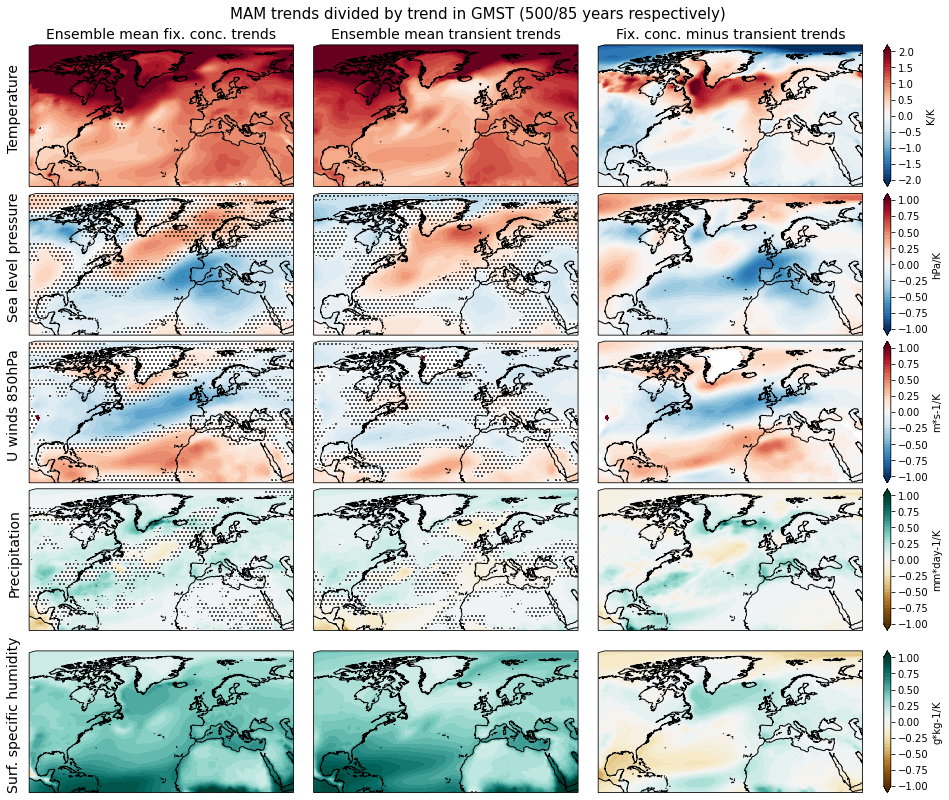

In [7]:
def check_sign_agreement(input):
    pos=np.where((input > 0)&(~np.isnan(input)), 1.0, 0)
    neg=np.where((input <= 0)&(~np.isnan(input)), 1.0, 0)
    # Calculate the sum of positive values
    sum_positive = np.sum(pos,axis=0)
    print(sum_positive.shape)

    # Calculate the sum of negative values
    sum_negative = np.sum(neg,axis=0)
    n_agree=np.maximum(sum_positive,sum_negative)
    print(n_agree.shape)
    return(n_agree)
    
# var='ua_850'
# var2='ua'
# files=sortbygmst(sorted(glob.glob('/gws/nopw/j04/realproj/users/adittus/intermediate_files/stable/'+var+'/'+var+'_?????.nc')))
# tasfiles=xr.open_mfdataset(files,combine='nested',concat_dim='cases',preprocess=preprocess)
# meanpattern=(rebase(seasaverage_3(tasfiles[var2],seas,window=window),files)).mean('cases').mean('year')*factor[var]


import matplotlib.colors as colors
f=plt.figure()
crs = ccrs.Robinson(central_longitude=0., globe=None)
colormap={'tas':plt.cm.RdBu_r,'pr':plt.cm.BrBG,'psl':plt.cm.RdBu_r,'ua_850':plt.cm.RdBu_r,'huss':plt.cm.BrBG,'prw':plt.cm.BrBG,'hurs':plt.cm.BrBG,'evspsbl':plt.cm.BrBG,'mrso':plt.cm.BrBG,'mrsos':plt.cm.BrBG,'zg_500':plt.cm.RdBu_r}
scale={'tas':2,'psl':1.,'ua_850':1,'pr':1,'huss':1.,'prw':5,'hurs':2,'evspsbl':2,'mrso':20,'mrsos':3,'zg_500':40}
var=['tas','psl','ua_850','pr','huss','hurs','pr','huss','evspsbl','hurs','mrsos','zg_500']
varname=['Temperature','Sea level pressure','U winds 850hPa','Precipitation','Surf. specific humidity','Relative Humidity','hurs','mrsos','Geo. height 500hPa',]
units=['K/K','hPa/K','m*s-1/K','mm*day-1/K','g*kg-1/K','%','hurs','mrsos','m']
vmin = -3 
vmax = 3
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)
n=0
nvars=5
reg='euro'
def plot_background(ax):
    if (reg=='global'):
        ax.set_global()
    else:
    # reg='euro'
        ax.set_extent([-100,50,10,90])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.)
    ax.set_anchor('S')
    # gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
    #               linewidth=1, color='black', alpha=1) #, linestyle='')
    # gl.top_labels = False
    # gl.bottom_labels = False
    # gl.left_labels = False
    # gl.right_labels = False
    # gl.xlines = False
    # gl.ylocator = mticker.FixedLocator([0])
    return ax

fig, axarr = plt.subplots(nrows=nvars, ncols=3, figsize=(13, 2.2*nvars), constrained_layout=True, subplot_kw={'projection': crs}) # figsize width then height
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)
for var in [var[0],var[1],var[2],var[3],var[4]]:
    print(var)
    print(n)
    cf1 = axlist[3*n].contourf(lon[var],lat[var],np.mean(trend[var]/global_trend[var][0:trend[var].shape[0],],axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
    axlist[3*n].contourf(lon[var],lat[var],check_sign_agreement(trend[var]/global_trend[var][0:trend[var].shape[0],]),levels=[-7,-4.5,0,4.5,7],hatches=["","...","...",""],transform=ccrs.PlateCarree(),colors=None,alpha=0,edgecolor='red') #,extend="both")
    # if (var == 'ua_850'):
    #     cf2 = axlist[3*n].contour(meanpattern.lon,meanpattern.lat,meanpattern,transform=ccrs.PlateCarree(),colors='gray') #,levels=np.linspace(np.nanmin(np.mean(stable[var],axis=(0,1))),np.nanmax(np.mean(stable[var],axis=(0,1))),10))
    if (n == 0):
        axlist[3*n].set_title('Ensemble mean fix. conc. trends',fontsize=14)
    cf1 = axlist[(3*n)+1].contourf(lon[var],lat[var],np.mean(transient_trend[var]/transient_gtrend[var],axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
    if (var != 'test'):
        axlist[(3*n)+1].contourf(lon[var],lat[var],check_sign_agreement(transient_trend[var]/transient_gtrend[var]),levels=[-17,-12.5,0,12.5,17],hatches=["","...","...",""],transform=ccrs.PlateCarree(),colors=None,alpha=0,edgecolor='red')
    if (n == 0):
        axlist[(3*n)+1].set_title('Ensemble mean transient trends',fontsize=14)
    # if (var == 'ua_850'):
    #     cf3 = axlist[7].contour(stable[var].lon,stable[var].lat,np.mean(transient[var],axis=(0,1)),transform=ccrs.PlateCarree(),colors='gray',levels=np.linspace(np.nanmin(np.mean(stable[var],axis=(0,1))),np.nanmax(np.mean(stable[var],axis=(0,1))),10))
    cf1 = axlist[(3*n)+2].contourf(lon[var],lat[var],np.mean(trend[var]/global_trend[var][0:trend[var].shape[0],],axis=0)-np.mean(transient_trend[var]/transient_gtrend[var],axis=0),np.linspace(-scale[var],scale[var],41),transform=ccrs.PlateCarree(),cmap=colormap[var],extend="both")
    if (n == 0):
        axlist[(3*n)+2].set_title('Fix. conc. minus transient trends',fontsize=14)
    plt.suptitle(str(seas)+" trends divided by trend in GMST ("+str(eind-sind)+"/85 years respectively)",fontsize=15)
    # plt.suptitle("Annual trends divided by trend in GMST",fontsize=14)
    cb1=fig.colorbar(cf1,ax=axlist[(3*n):((3*n)+3)],orientation='vertical',shrink=1,pad=0.025)
    cb1.set_label(units[n]) #,rotation=90,x=0, y=0.5, pad=0, verticalalignment='center',horizontalalignment='center')
    axlist[(3*n)].text(-0.03, 0.55, varname[n], va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axlist[3*n].transAxes,fontsize=14)
    # axlist[(3*n)].text(-0.05, 0.55, varname[n], va='bottom', ha='center',
    #     rotation='vertical', rotation_mode='anchor',
    #     transform=axlist[3*n].transAxes,fontsize=14)
    n+=1
# if (var == 'ua_850'):
#     axlist[6].clabel(cf2, cf2.levels, inline=True, fontsize=10)
#     axlist[7].clabel(cf3, cf3.levels[::2], inline=True, fontsize=10)
plt.savefig('paper_plots/trends_EM_'+str(seas)+'_'+reg+'_'+str(sind)+'-'+str(eind)+'_'+scenario+'.png',dpi=300)